In [ ]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights

# Define Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = os.listdir(data_path)  # List subdirectories (classes)
        self.files = []
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(data_path, class_name)
            for file_name in os.listdir(class_path):
                if file_name.endswith('.npy'):
                    self.files.append((class_name, os.path.join(class_path, file_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        class_name, file_path = self.files[idx]
        data = np.load(file_path)  # Load the .npy file (spectrogram)
        label = self.classes.index(class_name)

        if self.transform:
            data = self.transform(data)

        return data, label

# Define transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x).unsqueeze(0).repeat(3, 1, 1)),  # Convert numpy array to tensor and repeat the channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use ImageNet's standard normalization
])

# Paths to training/validation and testing data
train_val_path = 'train_val_spectrogram_npy'  # Replace with your training/validation data path
test_path = 'test_spectrogram_npy'  # Replace with your test data path

# Load the dataset
train_val_dataset = CustomDataset(data_path=train_val_path, transform=transform)

# Split into train and validation
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load test dataset
test_dataset = CustomDataset(data_path=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize ResNet50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # Using the recommended weights argument
model.fc = nn.Linear(model.fc.in_features, 8)  # 8 classes

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total*100:.2f}%")

    # Validate the model
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    print(f"Validation Accuracy: {val_correct/val_total*100:.2f}%")

# Save the model after training is complete
torch.save(model.state_dict(), 'resnet50_spectrogram_model.pth')  # Save model weights

# # Test the model
# model.eval()
# test_correct = 0
# test_total = 0
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         test_correct += (predicted == labels).sum().item()
#         test_total += labels.size(0)

# print(f"Test Accuracy: {test_correct/test_total*100:.2f}%")

Epoch [1/20], Loss: 0.8562, Accuracy: 71.67%
Validation Accuracy: 74.72%
Epoch [2/20], Loss: 0.4751, Accuracy: 85.06%
Validation Accuracy: 84.17%
Epoch [3/20], Loss: 0.3111, Accuracy: 90.56%
Validation Accuracy: 86.67%
Epoch [4/20], Loss: 0.2609, Accuracy: 91.48%
Validation Accuracy: 77.78%
Epoch [5/20], Loss: 0.1757, Accuracy: 94.10%
Validation Accuracy: 90.83%
Epoch [6/20], Loss: 0.1118, Accuracy: 96.33%
Validation Accuracy: 90.56%
Epoch [7/20], Loss: 0.1020, Accuracy: 96.48%
Validation Accuracy: 86.94%
Epoch [8/20], Loss: 0.1823, Accuracy: 94.20%
Validation Accuracy: 90.56%
Epoch [9/20], Loss: 0.0894, Accuracy: 97.65%
Validation Accuracy: 88.33%
Epoch [10/20], Loss: 0.0746, Accuracy: 97.53%
Validation Accuracy: 91.11%
Epoch [11/20], Loss: 0.1041, Accuracy: 96.45%
Validation Accuracy: 65.28%
Epoch [12/20], Loss: 0.0574, Accuracy: 98.09%
Validation Accuracy: 95.00%
Epoch [13/20], Loss: 0.0601, Accuracy: 98.73%
Validation Accuracy: 90.56%
Epoch [14/20], Loss: 0.0919, Accuracy: 97.22%
V

Confusion Matrix:
[[46  1  0  0  0  1  1  1]
 [ 0 47  0  1  0  0  1  1]
 [ 0 12 37  0  1  0  0  0]
 [ 0  0  0 47  0  2  0  1]
 [ 0  1  0  0 49  0  0  0]
 [ 0  1  0  1  4 44  0  0]
 [ 0  1  0  0  0  0 46  3]
 [ 0  2  0  1  1  1  0 45]]
Classification Report:
                       precision    recall  f1-score   support

 air_conditioner_test       1.00      0.92      0.96        50
children_playing_test       0.72      0.94      0.82        50
        dog_bark_test       1.00      0.74      0.85        50
        drilling_test       0.94      0.94      0.94        50
   engine_idling_test       0.89      0.98      0.93        50
      jackhammer_test       0.92      0.88      0.90        50
           siren_test       0.96      0.92      0.94        50
    street_music_test       0.88      0.90      0.89        50

             accuracy                           0.90       400
            macro avg       0.91      0.90      0.90       400
         weighted avg       0.91      0.90     

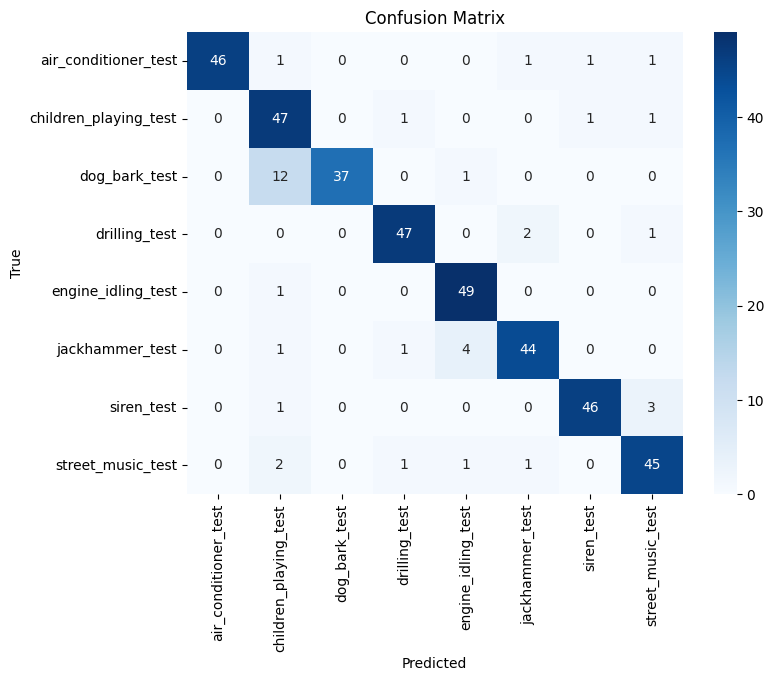

In [16]:
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = os.listdir(data_path)  # List subdirectories (classes)
        self.files = []
        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(data_path, class_name)
            for file_name in os.listdir(class_path):
                if file_name.endswith('.npy'):
                    self.files.append((class_name, os.path.join(class_path, file_name)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        class_name, file_path = self.files[idx]
        data = np.load(file_path)  # Load the .npy file (spectrogram)
        label = self.classes.index(class_name)

        if self.transform:
            data = self.transform(data)

        return data, label

# Define transformations
transform = transforms.Compose([
    transforms.Lambda(lambda x: torch.tensor(x).unsqueeze(0).repeat(3, 1, 1)),  # Convert numpy array to tensor and repeat the channel
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use ImageNet's standard normalization
])

# Path to test data
test_path = 'test_spectrogram_npy'  # Replace with your test data path

# Load the dataset
test_dataset = CustomDataset(data_path=test_path, transform=transform)

# Create DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize ResNet50 model
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # Using the recommended weights argument
model.fc = nn.Linear(model.fc.in_features, 8)  # 8 classes

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load('resnet50_spectrogram_model.pth'))  # Load model weights

# Set the model to evaluation mode
model.eval()

# Initialize variables to collect true labels and predictions
all_labels = []
all_predictions = []

# Evaluate on test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())  # Collect true labels
        all_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
class_report = classification_report(all_labels, all_predictions, target_names=test_dataset.classes)

# Print classification report
print("Classification Report:")
print(class_report)

# Save confusion matrix and classification report to files
# Save the confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

# Save the classification report to a text file
with open('classification_report.txt', 'w') as f:
    f.write(class_report)